# The Response of Sea Surface Temperature to Rain
Ongoing summary of research/analysis to serve as the skeleton for the eventual publication.

## Prologue: Pre-processing overview

### Variable Names

$\Delta SST_{skin}$ - departure of skin temperature (KT15) from 3-minute mean prior to rain onset

$t_{*SST}$ - time from rain onset to maximum SST response (maximum $\Delta SST_{skin}$)

$L_{rain}$ - length of rain event

$t_{*rain}$ - time from rain onset to peak rain rate

### Overview of DYNAMO dataset

The figure below shows a series of histograms of relevant variables for each of the 103 identified rain events on DYNAMO.
The events are largely ~1hr long and deposit ~15mm rain, with only a few very long events (>10hrs). The mean $\Delta SST_{skin}$ due to rain is $-0.51 ^\circ C$.

![Histograms](Histograms v1.png)


### Relationships between variables

The figure below attempts to relate both the maximum skin temperature deviation ($\Delta SST_{skin}$) and the time between rain onset and maxiumum skin temperature deviation ($t_{*SST}$) to other relevant parameters.
![Scatterplots](Scatterplots v1.png)

The relationship between $t_{*rain}$ and $t_{*SST}$ looks fairly robust and close to 1:1 (red line). It makes some intuitive sense that the time period of the largest rain rate would tend to correspond to the time period of the largest SST deviation.

The other relationship that may have some legs is between $L_{rain}$ vs. $t_{*SST}$. However, this correspondence may just reflect the agreement between $t_{*rain}$ and $t_{*SST}$, in that longer rain events may tend to take longer to reach their maximum rain rate. **Plot $L_{rain}$ vs. $t_{*rain}$ and verify.** 

### Normalized timeseries of temperature deviation

The figure below shows a bin-averaged timeseries of all 103 rain events, where rain onset for each event corresponds to T=0, and the timescale of the event is normalized by $t_{*SST}$, the time it takes to reach the maximum SST deviation. This means that the maximum $\Delta SST_{skin}$ always occurs at T=1. 

![Timeseries](Timeseries_v1.png)

It would seem to make more sense to **normalize the timescale in this figure by $t_{*rain}$ rather than $t_{*SST}$**, especially given the good correspondence between the two.

The **locations of the bins** also seem arbitrary and poorly chosen, as there is no bin centered on 0 or 1, the two most important parts of the timescale. 

There is very close temporal alignment of the trends in $\Delta SST_{skin}$, $\Delta T_{bulk}$, and $\Delta T_{air}$, with the drop in SST about double the drop in bulk water temperature. It is interesting that there is no time lag between the trends in SST and bulk temperature - likely due to some combination of these two factors:
    - insufficient temporal resolution between bins to see the delay
    - downward mixing occuring on sufficiently short timescales
    
**Come up with something other than the symbol delta to characterize these anomalies.**


#### Deb's scripts:
*SST_rain_comparison_ID_rainpeaks.m*    does the basic peak detection and collates met data from Edson.

*SST_rain_comparison_bin_average_interim.m*   plots some histograms and scatterplots

*SST_rain_comparison_with_anomaly.m*    Collates variables into structure Var

*SST_rain_comparison_peak_response.m*   Adds times to max SST response, time to recover, etc.

*SST_rain_comparison_bin_average_more.m*  bin averages to create composite event - scales to beginning of event, and produces unscaled time as well (want scaled!)

*SST_rain_comparison_bin_average_long_short.m*   bin averages to create
composite but selects out long events

## Overview of Falkor Dataset(s)

There is a major challenge in extending the rigor of the DYNAMO processing to the Falkor datasets:  **there was no rain sensor onboard the ship.** In 2016, the catamaran had a rain sensor, and in 2019, the SPIP had a rain sensor, but this limits us to rain events in which SPIP or Cat were in the waterfor the entire duration of the event. There are only 5 rain events recorded by SPIP in 2019 from start to end, and they are all extremely mild rain rates. 

However, there is another event from which we can get some really interesting information. On November 22, 2019, SPIP captured the process of a diurnal warm layer breaking down in the presence of an oncoming rain event, followed by the development of a cold freshwater lens on the surface in response to increased rainfall and decreasing wind forcing:

![Dep2RainSPIP](SPIP_SummaryPlot_deployment2_RainEvent.png)

**Calculate a dilution rate from this**

#### Mitie and KT15 data
**A key thing to account for when comparing SPIP data to shipboard observations is the potential separation between them. I will need to make a map of their tracks during the time periods of interest.**

The Mitie was recording 20 minutes of every hour, so during this rain event it recorded from 03:27 - 03:47. A screenshot of the Mitie at 3:47 is shown below:

![MitieS2Screengrab](Mitie_s2_screenshot1.png)

Let's take a look at this event as recorded by the KT-15s:
**Zappa can you provide the reference for the sky-correction algorithm?**

In [1]:
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
#import a KT15 labview data file:
kt = pd.read_csv('../Data/Working/Falkor19/KT15/2019_Falkor_325_043435.txt',                                   #filename to read in
                 delimiter='\s+', skiprows=1, header=None,                                                     #treat whitespace as the delimeter, ignore the header line
                 usecols=[0,1,2,3,4,5], names=['Date','Time','SeaRef','SeaTemp','SkyRef','SkyTemp'],           #use the first 6 columns, and name them as specified
                 parse_dates={'DateTime':[0,1]}, index_col=0,                                                  #parse the first two columns as a single DateTime, and make it the index column
                 na_values=['AMB'],                                                                            #list of other things the parser might encounter in these files, that should be treated like NaNs
                 dtype={'SeaRef':np.float64, 'SeaTemp':np.float64, 'SkyRef':np.float64, 'SkyTemp':np.float64}, #explicitly specify that data columns must be 64-bit floating point numbers
                 error_bad_lines=False, warn_bad_lines=True)                                                   #if there is a bad line in the data file, drop it from the file and show a warning, but continue parsing
kt.dropna(axis='index',how='any',inplace=True)                                                                 #drop any rows that have a NaN value in them
kt.head()

,SeaRef,SeaTemp,SkyRef,SkyTemp
DateTime,,,,
2019-11-21 04:34:36.153,31.51,27.94,31.69,22.40
2019-11-21 04:34:36.953,31.51,27.98,31.69,22.38
2019-11-21 04:34:37.754,31.51,27.90,31.69,22.31
2019-11-21 04:34:38.554,31.51,27.92,31.69,22.33
2019-11-21 04:34:39.354,31.51,27.94,31.69,22.31


In [7]:
#apply sky correction - what is the source for these coefficients?
K0u = -1.9151
K1u = 0.041767
K2u = -0.00033291
K3u = 1.0715e-06
K4u = -8.651e-10
K5u = K6u = K7u = K8u = 0 

K0d = -82.135
K1d = 2.293
K2d = -0.020287
K3d = 6.7301e-05
K4d = -5.2395e-08
K5d = K6d = K7d = K8d = 0

y0 = 136.33
A = 20.927
power = 0.40045

RadTempSKY = kt.SkyTemp + 273.16
RadTempSEA = kt.SeaTemp + 273.16
ReflectedSkyRad = K0u + K1u*RadTempSKY + K2u*RadTempSKY**2 + K3u*RadTempSKY**3 + K4u*RadTempSKY**4 + K5u*RadTempSKY**5 + K6u*RadTempSKY**6 + K7u*RadTempSKY**7 + K8u*RadTempSKY**8
TotalRad = K0d + K1d*RadTempSEA + K2d*RadTempSEA**2 + K3d*RadTempSEA**3 + K4d*RadTempSEA**4 + K5d*RadTempSEA**5 + K6d*RadTempSEA**6 + K7d*RadTempSEA**7 + K8d*RadTempSEA**8
SSTRad = TotalRad - ReflectedSkyRad
kt['SST_nocal'] = y0 + A*(SSTRad)**power - 273.16

We'll plot the KT-15 SST (sky-corrected, but not yet blackbody calibrated) for the time period of the SPIP deployment (plus a little extra at the end):

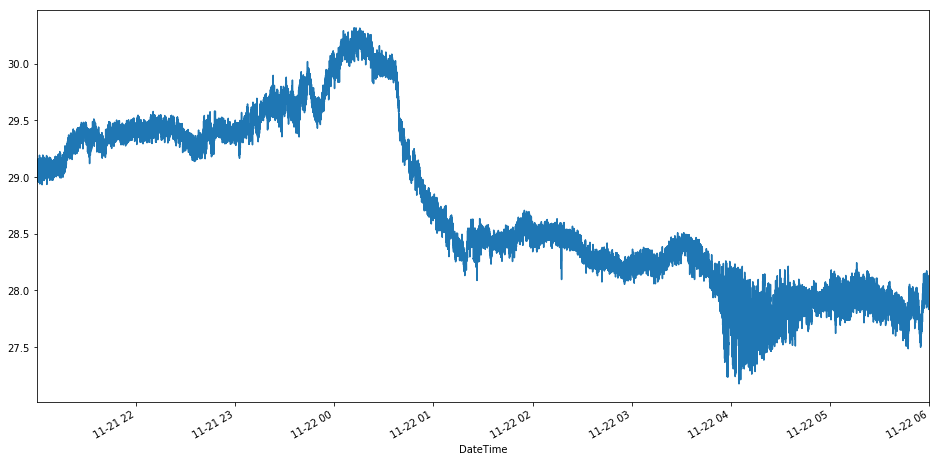

In [16]:
kt.SST_nocal.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].plot(figsize=(16,8))

Tought to look at a timeseries of this length with the full sub-second resolution. Let's apply a centered rolling mean to tease out the longer-term trends:

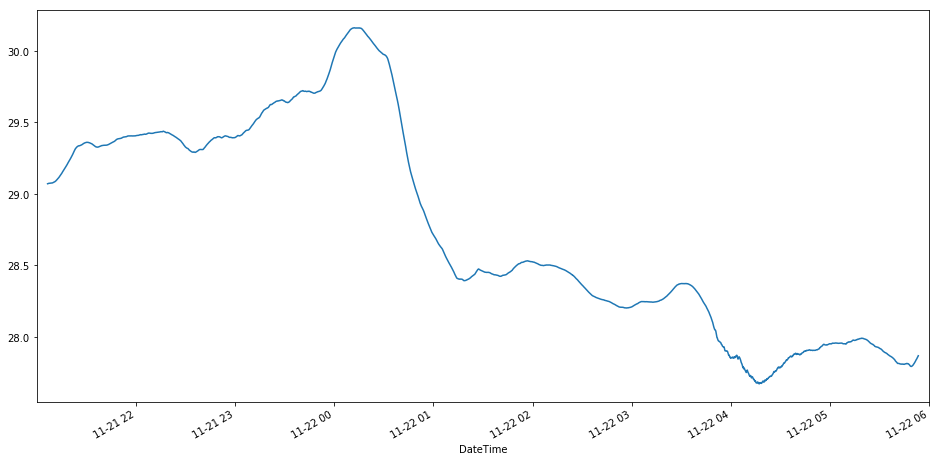

In [17]:
kt.SST_nocal.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].rolling(1000,center=True).mean().plot(figsize=(16,8))

Timeline of events _At SPIP's location_: 
1. Winds pick up around 00:30, destroying the DWL and likely leading to the sudden decrease in SST measured by the KT-15s. 
2. Light rain begins around 01:15, and SPIP observes a cold surface layer (likely due to the heat flux associated with the wind increase). 
3. Then from 03:45-04:00, the rain rate increases greatly and a cold freshwater lens develops in the upper ~1.5m. We see that reflected in the KT15 data as well, a significant drop in the same time period. 
4. Unfortunately SPIP was pulled shortly after 4:00, but the KT15 data does suggest that the rain event did not last much longer than that. Perhaps we could use ship met data to corroborate the story of the storm passing. The Mitie makes observations again from 04:27-04:47, so that could also give us insight into the tail end of the event. 

**note that the ship was maneuvering throughout this entire event, we will have to be very careful about that**

**Do the same treatment as Dynamo for Falkor16+19 rain events (piece together rain onset times from public cat data)**

Read BAMS article (Chen & Moum) about DYNAMO and Laxague+Zappa article about rain event from 2016.

Should also refer to some SPURS work - Zappa to find

Katsaros 198X paper shows exactly how to generate the sky correction coefficients. Zappa 1998 Appendix also talks about this.

Add 9-11um instrument to toolbox (once Zappa finds igor function)

# Body of Analysis
## Section 1: Dynamo

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as datetime
import glob
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from scipy.signal import find_peaks

#### Dynamo Rain Detection

**Questions to discuss with Zappa today: **
- how to classify events that start with a little rain and then slow down to essentially zero, then ramp up big time (not addressed by Deb)
- how to deal with events with multiple peaks (treated as separate events by Deb, as best I can tell)
- minimum rainfall rate to consider an 'event' (Deb set to 45 mm/hr, not unreasonable but does exclude many events and no justification provided)

From Deb's peak detection algorithm:" A point is considered a maximum peak if it has the maximal
value, and was preceded (to the left) by a value lower by DELTA."

Variables to calculate to characterize each dataset:
- Max SST response
- Time of max SST response
- Cumulative rain
- Length of rain event
- Time of maximum rain rate


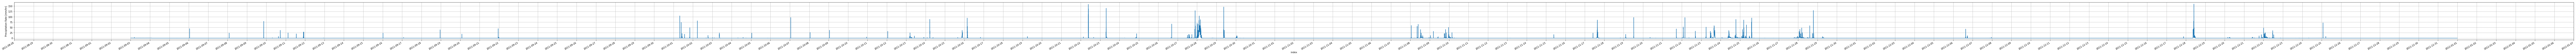

In [2]:
#import rain data
revelle_datapath = '..\Data\Level_3\Dynamo\Revelle_FluxData\Revelle_All_Legs.cdf'
rv = xr.open_dataset(revelle_datapath)
plt.subplots(figsize=(200,3),facecolor='w')
rv.P.plot()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))   #to get a tick every day minutes
plt.grid()

Slice every separate rain event out first (defined as being at least 'min_duration' long and surrounded by at least 'min_separation' minutes of zero precipitation). Then examine the plots of all rain events to tune parameters and identify any that should be removed...

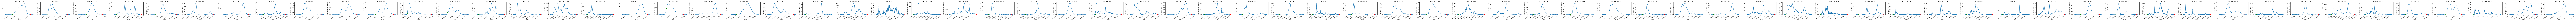

In [3]:
from RainEvent_Toolbox import find_rain_events
rain_event_list = find_rain_events(dataset = rv, 
                                   min_duration = 10,
                                   min_separation = 5,
                                   threshold = 10,
                                   noise_floor = 0,
                                   front_pad = 5, 
                                   end_pad = 3)

Plot SST data on top of the events:

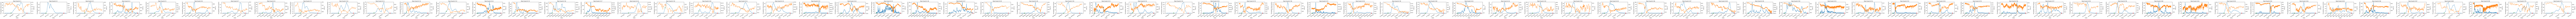

In [4]:
#import SST data
kt_dynamo = xr.open_dataset('../Data/Level_3/Dynamo/KT15/Dynamo_KT15_CalibratedSST.cdf')
#resample SST for cleaner plot
kt_1m = kt_dynamo.sortby(kt_dynamo.index).SST.resample(index='10s').mean()

fig, axx = plt.subplots(nrows=1, ncols=len(rain_event_list),facecolor='w',figsize=(400,3))
for event_num in np.arange(0,len(rain_event_list)):
    #extract start and end times
    start = rain_event_list[event_num].attrs['Rain Onset']
    end = rain_event_list[event_num].attrs['Rain End']
    first = rain_event_list[event_num].index[0]
    last = rain_event_list[event_num].index[-1]
    #plot precipitation rate
    rain_event_list[event_num].P.plot.line('-o',ax=axx[event_num],markersize=3,fillstyle=None)
    #plot SST
    ax2 = axx[event_num].twinx()
    kt_1m.sel(index=slice(first,last)).plot.line('C1',ax=ax2,fillstyle=None)
    ax2.set_ylabel('SST (C)')
    #plot start and end times
    axx[event_num].plot(start,rain_event_list[event_num].P.sel(index=start),'.g',markersize=12,fillstyle=None)
    axx[event_num].plot(end,rain_event_list[event_num].P.sel(index=end),'.r',markersize=12,fillstyle=None)
    #title
    axx[event_num].set_title(f'Rain Event # {event_num+1}')

plt.tight_layout()

## Appendix 1: KT-15 Processing

We will follow the same importing steps multiple times, once for each experiment. Start by importing all the python packages we'll need, along with the custom functions contained in the module 'KT15_Toolbox.py'.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import glob
from matplotlib import pyplot as plt
%matplotlib inline
#plt.style.use("classic")

from KT15_Toolbox import KT15_importraw, KT15_labcalibration, KT15_calibrate_skycorrect82

### - Falkor 2019 -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [3]:
#Falkor 2019: Takes ~7 minutes to run. 
KT15_importraw(data_folder = '..\Data\Level_0\Falkor19\KT15',
               output_path = '..\Data\Level_1\Falkor19\KT15', 
               sea_serial = 7417,
               sky_serial = 7409, 
               experiment = 'Falkor19')

Next we'll import calibration data acquired in the Lab while looking at a blackbody, and extract a linear fit from the data that allows us to calibrate our field measurements and increase their accuracy.

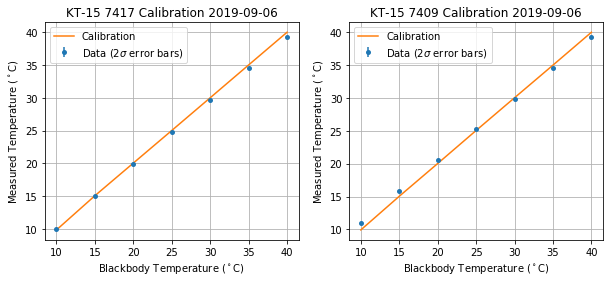

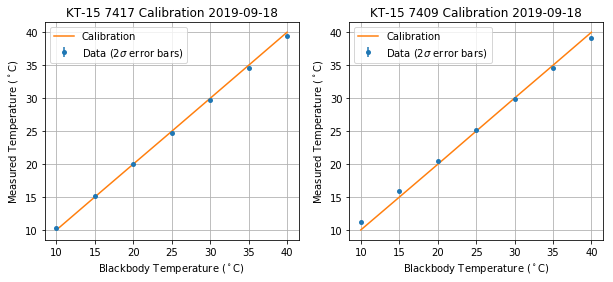

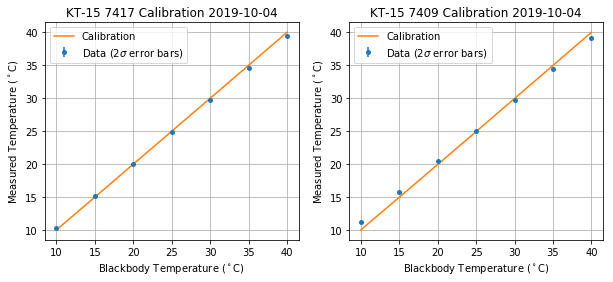

In [2]:
for cal_folder in glob.glob('../Data/Level_0/Falkor19/KT15_LabCalibrations/*'):  
    KT15_labcalibration(data_folder = cal_folder,
                        output_path = '../Data/Level_1/Falkor19/KT15_LabCalibrations', 
                        caltemps = [10,15,20,25,30,35,40])

We are ready to apply the lab calibrations and sky-correct the data:

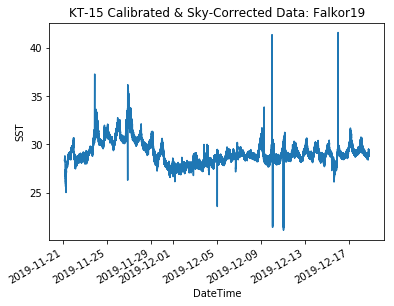

In [2]:
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Falkor19/KT15/Falkor19_KT15_7417_7409.cdf',
                            output_path = '../Data/Level_3/Falkor19/KT15/',
                            cal_path = '../Data/Level_1/Falkor19/KT15_LabCalibrations/')

The KT-15 SST is now an L3 product, ready for use in science analysis in the body of the paper.

### - Falkor 2016 -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [ ]:
#Falkor 2016: Takes ~7 minutes to run. Note the sea and sky instruments are opposite from Falkor19
KT15_importraw(data_folder = '../Data/Level_0/Falkor16/KT15/',
               output_path = '../Data/Level_1/Falkor16/KT15/', 
               sea_serial = 7409,
               sky_serial = 7417, 
               experiment = 'Falkor16')

Next we'll import calibration data acquired in the Lab while looking at a blackbody, and extract a linear fit from the data that allows us to calibrate our field measurements and increase their accuracy.

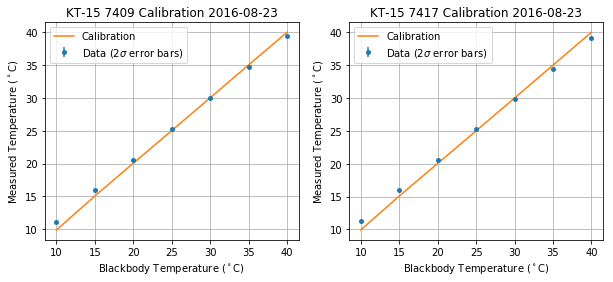

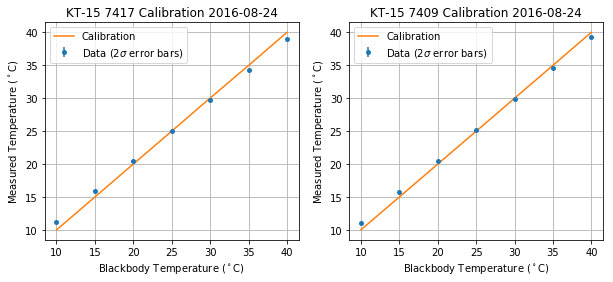

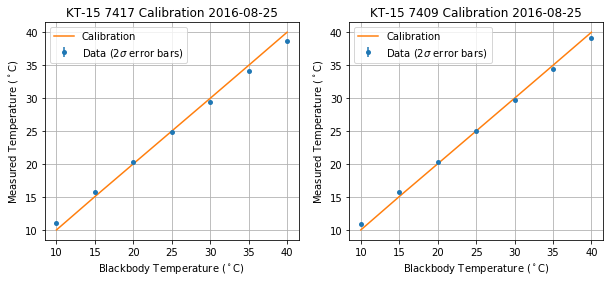

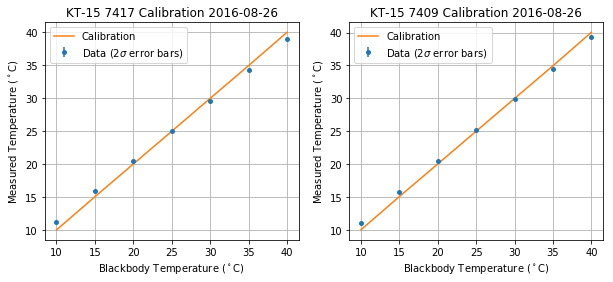

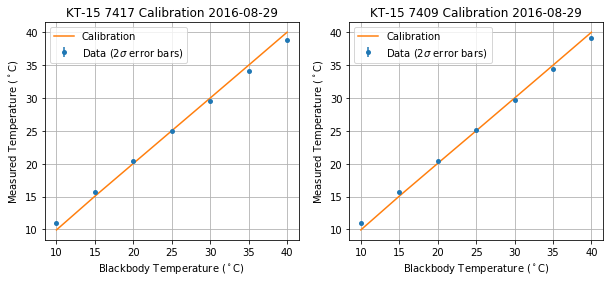

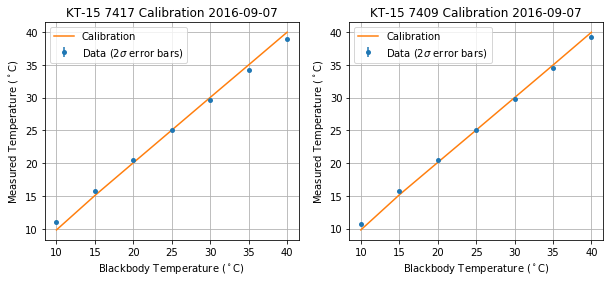

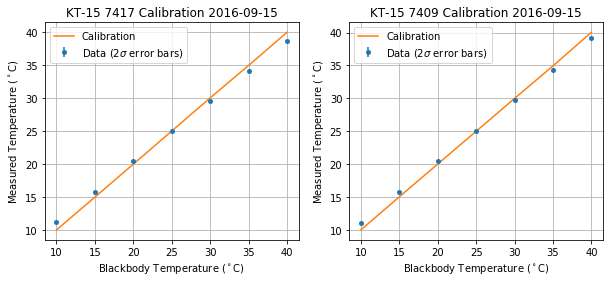

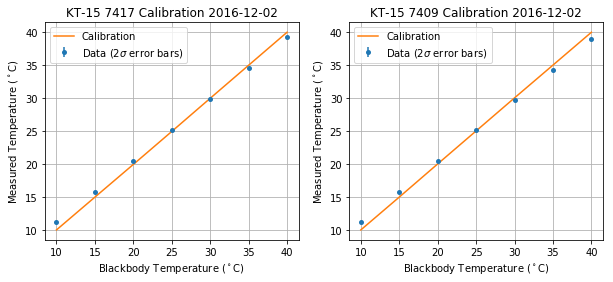

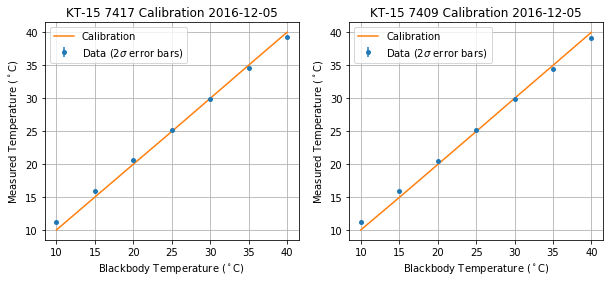

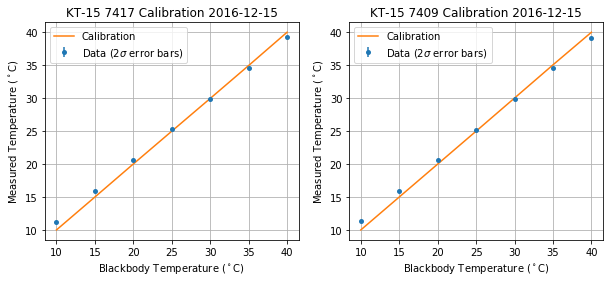

In [3]:
for cal_folder in glob.glob('../Data/Level_0/Falkor16/KT15_LabCalibrations/*'):  
    KT15_labcalibration(data_folder = cal_folder,
                        output_path = '../Data/Level_1/Falkor16/KT15_LabCalibrations', 
                        caltemps = [10,15,20,25,30,35,40])

We are ready to apply the lab calibrations and sky-correct the data:

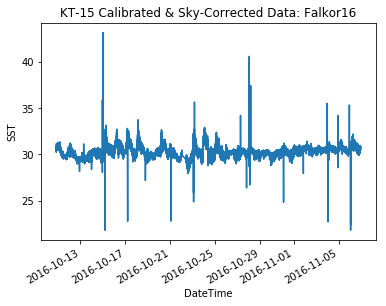

In [4]:
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Falkor16/KT15/Falkor16_KT15_7409_7417.cdf',
                            output_path = '../Data/Level_3/Falkor16/KT15/',
                            cal_path = '../Data/Level_1/Falkor16/KT15_LabCalibrations/')

The KT-15 SST is now an L3 product, ready for use in science analysis in the body of the paper.

### - Dynamo -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [ ]:
#Dynamo 2011: Takes ~30 minutes to run.
KT15_importraw(data_folder = '../Data/Level_0/Dynamo/KT15/',
               output_path = '../Data/Level_1/Dynamo/KT15/', 
               sea_serial = 7409,
               sky_serial = 7417, 
               experiment = 'Dynamo')

The KT-15s were calibrated by Deb using constants "calculated by Eric circa 2007" and "in use until at least June 2013". It is critical to note that her code treats "a" as the y-intercept and "b" as the slope, which is counter-intuitive to me so I need to keep that straight. These are the coefficients:

- Upa = 2.6117;       % +/- 0.0344	(yint) % KT7417
- Upb = 0.90621;      % +/- 0.00143 (slope)
- Downa = 1.4897;     % +/- 0.0281	(yint) %KT7409
- Downb = 0.94989;    % +/- 0.00117 (slope)

It appears there was also a calibration done in 2014, with these coefficients:

- Upb = 0.9509; (slope)      
- Upa = 1.28615; (yint)      
- Downb = 0.9726; (slope)    
- Downa = 0.65781; (yint)

Let's compare these coefficients to the ones on the two Falkor experiments:

In [8]:
xr.open_dataset('../Data/Level_3/Falkor16/KT15/Falkor16_KT15_CalibratedSST.cdf').attrs

OrderedDict([('experiment', 'Falkor16'),
             ('sea_serial', 7409),
             ('sky_serial', 7417),
             ('sea_slope', 0.9356645728890147),
             ('sea_yint', 1.7417109487690503),
             ('sky_slope', 0.9270068573636857),
             ('sky_yint', 1.9150189288935866)])

In [9]:
xr.open_dataset('../Data/Level_3/Falkor19/KT15/Falkor19_KT15_CalibratedSST.cdf').attrs

OrderedDict([('experiment', 'Falkor19'),
             ('sea_serial', 7417),
             ('sky_serial', 7409),
             ('sea_slope', 0.9727612699942666),
             ('sea_yint', 0.4628266465754239),
             ('sky_slope', 0.9338967855693827),
             ('sky_yint', 1.8237596338977193)])

Generally, all the slopes are very close to 1, and the y-intercepts vary between 0.5-2. All seems quite reasonable. Still, given the inconsistencies in Deb's code (such as a section in which she was trying switching the slopes and yintercepts for reasons I cannot fathom), I'd like to get a hold of the actual raw calibration data. But I cannot find it in any obvious place on the servers, so I may have no choice but to trust these coefficients from Deb's code...

For now, because they seem reasonable enough, I'll just manually make cal files for both the 2007 and 2014 coefficients:

In [6]:
output_path = '../Data/Level_1/Dynamo/KT15_LabCalibrations/'

cal_7409_2007 = xr.Dataset(attrs={'serial_number':7409,
                                  'calibration_date':'2007',
                                  'slope':0.94989,
                                  'yint': 1.4897})
cal_7409_2007.to_netcdf(output_path+'/KT15_LabCalibration_7409_2007-00-00.cdf')

cal_7409_2014 = xr.Dataset(attrs={'serial_number':7409,
                                  'calibration_date':'2014',
                                  'slope':0.9726,
                                  'yint': 0.65781})
cal_7409_2014.to_netcdf(output_path+'/KT15_LabCalibration_7409_2014-00-00.cdf')

cal_7417_2007 = xr.Dataset(attrs={'serial_number':7417,
                                  'calibration_date':'2007',
                                  'slope':0.90621,
                                  'yint': 2.6117})
cal_7417_2007.to_netcdf(output_path+'/KT15_LabCalibration_7417_2007-00-00.cdf')

cal_7417_2014 = xr.Dataset(attrs={'serial_number':7417,
                                  'calibration_date':'2014',
                                  'slope':0.9509,
                                  'yint': 1.28615})
cal_7417_2014.to_netcdf(output_path+'/KT15_LabCalibration_7417_2014-00-00.cdf')

We are ready to apply the lab calibrations and sky-correct the data:

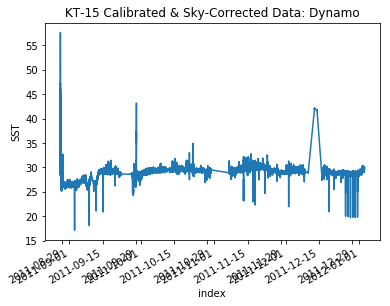

In [11]:
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Dynamo/KT15/Dynamo_KT15_7409_7417.cdf',
                            output_path = '../Data/Level_3/Dynamo/KT15/',
                            cal_path = '../Data/Level_1/Dynamo/KT15_LabCalibrations/')

The KT-15 SST is now an L3 product, ready for use in science analysis in the body of the paper.

## Appendix 2: Rain Data Processing

The data from R/V Revelle was provided by Jim Edson in a L1 .mat format. Here we'll import it and save the relevant variables into a science-ready netcdf.

From the Readme Edson included with the Revelle data files, these are the variables:

| Variable | Description |
|:-----|:-----|
|Yday |     Decimal yearday (UTC)
|Lat  |     Latitude (deg)
|Lon  |     Longitude (deg)
|SOG  |     Speed over ground (m/s)
|COG  |     Course over ground (deg)
|Heading|   Ship's heading (deg)
|Cspd |     Current speed (m/s)
|Cdir |     Current direction (deg) from
|U10  |     Wind speed (m/s) relative to earth adjusted to 10 m
|Wdir |     Wind direction (deg) from relative to earth
|Ur10 |     Wind speed (m/s) relative to water adjusted to 10 m
|WdirR|     Wind direction (deg) from relative to water
|Pair10|    Pressure (mb) adjusted to 10 m
|RH10  |    Relative humidity(%) adjusted to 10 m
|T10   |    Temperature (C) adjusted to 10 m
|Tsea  |    Near surface sea temperature (C) from Sea snake
|SST   |    Sea surface temperature (C) from Tsea minus cool skin
|Q10  |     Specific humidity (g/Kg) adjusted to 10 m
|Qsea |     Specific humidity (g/Kg) 'near' ocean surface from sea snake
|SSQ  |     Sea surface specific humidity (g/Kg) from Qsea minus cool skin
|stress |   Surface stress (N/m2) measured relative to water
|shf  |     Sensible heat flux (W/m2)
|lhf  |     Latent heat flux (W/m2)
|rhf  |     Sensible heat flux from rain (W/m2)
|Solarup |  Reflected solar (W/m2) estimated from Payne (1972)
|Solardn |  Measured downwelling solar (W/m2)
|IRup    |  Upwelling IR (W/m2) computed from SST 
|IRdn    |  Measured downwelling IR (W/m2)
|E       |  Evaporation rate (mm/hr)
|P  |       Precipitation rate (mm/hr)
|Evap |      Accumulated evaporation for Leg (mm)
|Precip |   Accumulated precipitation for Leg (mm)
|Interped | 1=data interpolated due to poor relative winds (0=no interpolation)
           

In [20]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import glob
import tqdm
import time
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.io import loadmat

In [23]:
#generate list of 1min Revelle .mat data files in the Level-1 Folder (provided by Jim Edson)
data_folder = '../Data/Level_1/Dynamo/Revelle_FluxData/'
files = glob.glob(data_folder + '/*1minute*.mat')

Revelle_dfs = []

#iterate over list of files
for filepath in files: 
    #import file as a dictionary of numpy arrays using the scipy loadmat function
    Revelle_Leg = loadmat(filepath)
    print(filepath)
    #drop the metadata keys from the dictionary so that all the remaining arrays are the same size
    del Revelle_Leg['__header__']
    del Revelle_Leg['__version__']
    del Revelle_Leg['__globals__']

    #initialize pandas dataframe with time as the index
    year = 2011
    date = dt.datetime(year, 1, 1) + pd.to_timedelta(Revelle_Leg['yday'][0]-1,unit='days')
    Revelle_df = pd.DataFrame(index=date)

    #iterate over each key in the dict and add to the pandas dataframe as a new column
    for key in Revelle_Leg:
        Revelle_df[key] = Revelle_Leg[key][0].tolist()
    
    #add the pandas dataframe to a list of dataframes
    Revelle_dfs.append(Revelle_df)

#concatenate all the dataframes in the list into one complete dataframe along the vertical (index) axis
RevelleData = pd.concat(Revelle_dfs, axis=0, sort=True)
RevelleData

../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg1_r2b.mat
../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg2_r2b.mat
../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg3_r2b.mat
../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg4_r2b.mat


,COG,E,Evap,Heading,IRdn,IRup,Lat,Lon,P,Pair10,...,cspd,dSolar,interped,lhf,rhf,shf,stress,wdir,wdirR,yday
2011-09-03 00:00:00.000000000,268.961884,0.228639,0.003811,262.923397,-382.506191,452.824898,-12.274912,106.220161,0.257143,1012.284125,...,0.285533,-1509.480833,0,154.872008,1.185813,5.216234,0.102725,105.424844,103.198039,246.000000
2011-09-03 00:01:00.000000000,268.963806,0.204495,0.007219,264.991871,-384.263144,452.923098,-12.274981,106.220161,0.257143,1012.291724,...,0.285533,-1505.780833,0,138.517440,1.109251,4.662841,0.087392,108.489894,106.128853,246.000694
2011-09-03 00:02:00.000000000,271.233568,0.199075,0.010537,268.161121,-385.896532,453.041133,-12.275017,106.218556,0.257143,1012.319897,...,0.285533,-1502.080833,0,134.845090,1.071910,4.143116,0.087506,111.257453,108.904330,246.001389
2011-09-03 00:03:00.000000000,273.610960,0.212163,0.014073,271.179214,-387.317475,453.148466,-12.274880,106.215264,0.257143,1012.351243,...,0.285020,-1498.380833,0,143.710090,1.088119,4.069445,0.100858,111.248292,109.019077,246.002083
2011-09-03 00:04:00.000000000,272.700386,0.216773,0.017686,270.285734,-388.416951,453.202267,-12.274645,106.211977,0.257143,1012.362687,...,0.284493,-1494.680833,0,146.831901,1.102484,4.587424,0.104227,109.307034,107.103552,246.002778
2011-09-03 00:05:00.000000000,271.151632,0.217844,0.021316,267.253357,-389.626009,453.255865,-12.274550,106.208697,0.257143,1012.367415,...,0.284493,-1490.980833,0,147.557455,1.104680,4.992561,0.105494,108.084373,105.888115,246.003472
2011-09-03 00:06:00.000000000,270.529349,0.217225,0.024937,266.722732,-390.548813,453.285644,-12.274533,106.205414,0.257143,1012.382334,...,0.284493,-1487.280833,0,147.137400,1.111869,5.069588,0.103101,106.349036,104.133260,246.004167
2011-09-03 00:07:00.000000000,270.705541,0.208690,0.028415,267.997286,-391.456090,453.303461,-12.274498,106.202127,0.257143,1012.401298,...,0.284493,-1483.580833,0,141.356251,1.107756,4.839560,0.092722,104.007415,101.706463,246.004861
2011-09-03 00:08:00.000000000,270.998061,0.201547,0.031774,268.234582,-391.869076,453.319752,-12.274438,106.198826,0.257143,1012.396376,...,0.284848,-1479.880833,0,136.517304,1.095899,4.696084,0.086073,104.610306,102.242479,246.005556
2011-09-03 00:09:00.000000000,271.112588,0.194422,0.035015,268.078593,-392.143426,453.317622,-12.274380,106.195520,0.257143,1012.396495,...,0.285231,-1476.180833,0,131.691465,1.093168,4.351690,0.077869,105.996341,103.534735,246.006250


In [31]:
#convert to xarray and fill out metadata (which will make plots self-labeling moving forwards)
Revelle_xr = RevelleData.to_xarray()

Revelle_xr.attrs['experiment'] = 'DYNAMO'

Revelle_xr.Lat.attrs['long_name'] = 'Latitude'
Revelle_xr.Lat.attrs['units'] = 'deg'

Revelle_xr.Lon.attrs['long_name'] = 'Longitude'
Revelle_xr.Lon.attrs['units'] = 'deg'

Revelle_xr.SOG.attrs['long_name'] = 'Speed Over Ground'
Revelle_xr.SOG.attrs['units'] = 'm/s'

Revelle_xr.COG.attrs['long_name'] = 'Course Over Ground'
Revelle_xr.COG.attrs['units'] = 'deg'

Revelle_xr.Heading.attrs['long_name'] = 'Ships Heading'
Revelle_xr.Heading.attrs['units'] = 'deg'

Revelle_xr.cspd.attrs['long_name'] = 'Current Speed'
Revelle_xr.cspd.attrs['units'] = 'm/s'

Revelle_xr.cdir.attrs['long_name'] = 'Current Direction (from)'
Revelle_xr.cdir.attrs['units'] = 'deg'

Revelle_xr.U10.attrs['long_name'] = '10m Wind Speed (relative to earth)'
Revelle_xr.U10.attrs['units'] = 'm/s'

Revelle_xr.wdir.attrs['long_name'] = 'Wind Direction (from, relative to earth)'
Revelle_xr.wdir.attrs['units'] = 'deg'

Revelle_xr.Ur10.attrs['long_name'] = '10m Wind Speed (relative to water)'
Revelle_xr.Ur10.attrs['units'] = 'm/s'

Revelle_xr.wdirR.attrs['long_name'] = 'Wind Direction (relative to water)'
Revelle_xr.wdirR.attrs['units'] = 'deg'

Revelle_xr.Pair10.attrs['long_name'] = '10m Air Pressure'
Revelle_xr.Pair10.attrs['units'] = 'mbar'

Revelle_xr.RH10.attrs['long_name'] = '10m Relative Humidity'
Revelle_xr.RH10.attrs['units'] = '%'

Revelle_xr.RH02.attrs['long_name'] = '2m Relative Humidity'
Revelle_xr.RH02.attrs['units'] = '%'

Revelle_xr.T10.attrs['long_name'] = '10m Air Temperature'
Revelle_xr.T10.attrs['units'] = 'C'

Revelle_xr.T02.attrs['long_name'] = '2m Air Temperature'
Revelle_xr.T02.attrs['units'] = 'C'

Revelle_xr.Tsea.attrs['long_name'] = 'Near-surface temperature (sea snake)'
Revelle_xr.Tsea.attrs['units'] = 'C'

Revelle_xr.TseaTSG.attrs['long_name'] = 'Ship intake temperature'
Revelle_xr.TseaTSG.attrs['units'] = 'C'

Revelle_xr.SST.attrs['long_name'] = 'SST calculated from sea snake minus cool skin'
Revelle_xr.SST.attrs['units'] = 'C'

Revelle_xr.Q10.attrs['long_name'] = '10m Specific Humidity'
Revelle_xr.Q10.attrs['units'] = 'g/kg'

Revelle_xr.Q02.attrs['long_name'] = '2m Specific Humidity'
Revelle_xr.Q02.attrs['units'] = 'g/kg'

Revelle_xr.Qsea.attrs['long_name'] = 'Specific Humidity "near" ocean surface (sea snake)'
Revelle_xr.Qsea.attrs['units'] = 'g/kg'

Revelle_xr.SSQ.attrs['long_name'] = 'Sea Surface Specific Humidity from sea snake minus cool skin'
Revelle_xr.SSQ.attrs['units'] = 'g/kg'

Revelle_xr.stress.attrs['long_name'] = 'Surface stress relative to water'
Revelle_xr.stress.attrs['units'] = 'N/m^2'

Revelle_xr.shf.attrs['long_name'] = 'Sensible Heat Flux'
Revelle_xr.shf.attrs['units'] = 'W/m^2'

Revelle_xr.lhf.attrs['long_name'] = 'Latent Heat Flux'
Revelle_xr.lhf.attrs['units'] = 'W/m^2'

Revelle_xr.rhf.attrs['long_name'] = 'Sensible Heat Flux From Rain'
Revelle_xr.rhf.attrs['units'] = 'W/m^2'

Revelle_xr.Solarup.attrs['long_name'] = 'Reflected Solar estimated from Payne (1972)'
Revelle_xr.Solarup.attrs['units'] = 'W/m^2'

Revelle_xr.Solardn.attrs['long_name'] = 'Measured Downwelling Solar'
Revelle_xr.Solardn.attrs['units'] = 'W/m^2'

Revelle_xr.IRup.attrs['long_name'] = 'Upwelling IR computed from SST'
Revelle_xr.IRup.attrs['units'] = 'W/m^2'

Revelle_xr.IRdn.attrs['long_name'] = 'Measured Downwelling IR'
Revelle_xr.IRdn.attrs['units'] = 'W/m^2'

Revelle_xr.E.attrs['long_name'] = 'Evaporation Rate'
Revelle_xr.E.attrs['units'] = 'mm/hr'

Revelle_xr.P.attrs['long_name'] = 'Precipitation Rate'
Revelle_xr.P.attrs['units'] = 'mm/hr'

Revelle_xr.Evap.attrs['long_name'] = 'Accumulated evaporation for cruise leg'
Revelle_xr.Evap.attrs['units'] = 'mm'

Revelle_xr.Precip.attrs['long_name'] = 'Acummulated precipitation for cruise leg'
Revelle_xr.Precip.attrs['units'] = 'mm'

Revelle_xr.interped.attrs['long_name'] = '1=data interpolated due to poor relative winds (0=no interpolation)'
Revelle_xr.interped.attrs['units'] = 'n/a'

Revelle_xr.SalTSG.attrs['long_name'] = 'Salinity at ship intake'
Revelle_xr.SalTSG.attrs['units'] = 'psu'

In [40]:
#save as L3 data product
Revelle_xr.to_netcdf('..\Data\Level_3\Dynamo\Revelle_FluxData\Revelle_All_Legs.cdf')

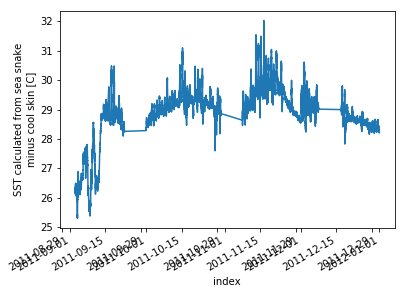

In [38]:
plt.subplots(facecolor='w')
Revelle_xr.SST.plot()

## Function Development